In [1]:
# how to set to GPU***
import learn as learn
import numpy as np
import pandas as pd
import os
import wandb.wandb_torch as wtorch
import fastai.vision.all as fvision
import sys
import timm
import torch.nn.functional as tnnf
import torch
import wandb
from glob import glob
from os import walk
from fastai.learner import Learner
from fastai.callback.tracker import SaveModelCallback
from fastai.callback.tracker import EarlyStoppingCallback

#torch.cuda.is_available = lambda : False
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def file_loader():
    path = 'petfinder-pawpularity-score/'

    train_df = pd.read_csv(path + 'train.csv')#load csv
    test_df = pd.read_csv(path + 'test.csv')
    train_jpg = glob(path + "train/*.jpg")#glob searches entire folder for jpg
    test_jpg = glob(path + "test/*.jpg")

    print('test_jpg type is ', type(test_jpg[0]), ' with length of ', len(test_jpg))
    print(test_jpg[0])
    return train_df, test_df, train_jpg, test_jpg, path

train_df, test_df, train_jpg, test_jpg, path = file_loader()

test_jpg type is  <class 'str'>  with length of  8
petfinder-pawpularity-score/test\4128bae22183829d2b5fea10effdb0c3.jpg


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Subject Focus  9912 non-null   int64 
 1   Eyes           9912 non-null   int64 
 2   Face           9912 non-null   int64 
 3   Near           9912 non-null   int64 
 4   Action         9912 non-null   int64 
 5   Accessory      9912 non-null   int64 
 6   Group          9912 non-null   int64 
 7   Collage        9912 non-null   int64 
 8   Human          9912 non-null   int64 
 9   Occlusion      9912 non-null   int64 
 10  Info           9912 non-null   int64 
 11  Blur           9912 non-null   int64 
 12  Pawpularity    9912 non-null   int64 
 13  path           9912 non-null   object
dtypes: int64(13), object(1)
memory usage: 1.1+ MB
None
Mean Pawpularity score is 38.03904358353511
Median Pawpularity score is 33.0
Standard deviation of the Pawpularity score is 20.59199010577444
There a

c:\users\user\documents\petbuilders2\venv\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


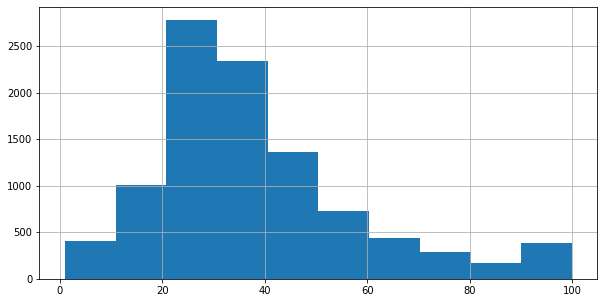

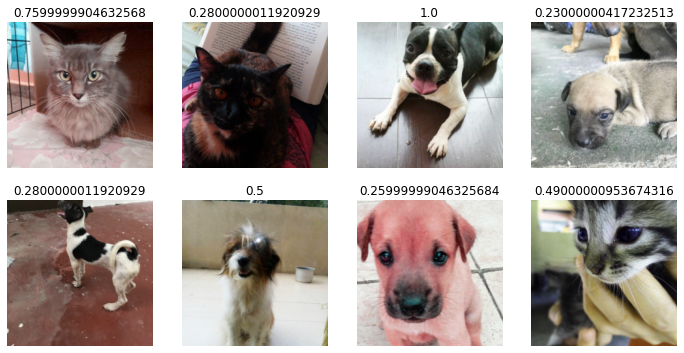

In [3]:
def data_loader(train_df, test_df, train_jpg, test_jpg, dataset_path):
    fvision.set_seed(999, reproducible=True)
    train_df['path'] = train_df['Id'].map(lambda x: str(dataset_path + 'train/' + x) + '.jpg')
    train_df = train_df.drop(columns=['Id'])
    train_df = train_df.sample(frac=1).reset_index(drop=True)  # randomize data
    print(train_df.info(max_cols=train_df.shape[1]))
    train_df['Pawpularity'].hist(figsize=(10, 5))
    print(f"Mean Pawpularity score is {train_df['Pawpularity'].mean()}")
    print(f"Median Pawpularity score is {train_df['Pawpularity'].median()}")
    print(f"Standard deviation of the Pawpularity score is {train_df['Pawpularity'].std()}")
    print(f"There are {len(train_df['Pawpularity'].unique())} unique values of Pawpularity score")
    train_df['norm_score'] = train_df['Pawpularity'] / 100
    print(train_df['norm_score'])
    im = fvision.Image.open(train_df['path'][1])
    width, height = im.size
    print(width, height)
    dls2 = fvision.ImageDataLoaders.from_df(train_df,  # pass in train dataframe
                                                      valid_pct=0.4,  # 60-40 random split
                                                      seed=999,
                                                      fn_col='path',
                                                      # dataframe
                                                      label_col='norm_score', #first column
                                                      y_block=fvision.RegressionBlock,
                                                      bs=8,  #batch size
                                                      num_workers=12, #threads, doesn't work due to windows error
                                                      item_tfms=fvision.Resize(224),#image size to match swin transformer
                                                      # pass in item_tfms
                                                      batch_tfms=fvision.setup_aug_tfms(
                                                          [fvision.Brightness(),
                                                           fvision.Contrast(),
                                                           fvision.Hue(),
                                                           fvision.Saturation()]))
    dls2.show_batch()
    return dls2

dls = data_loader(train_df, test_df, train_jpg, test_jpg, path)
health = timm.create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=dls.c)

In [4]:
def petfinder_rmse(monitor, target):
    return 100 * torch.sqrt(tnnf.mse_loss(tnnf.sigmoid(monitor.flatten()), target))


Test


c:\users\user\documents\petbuilders2\venv\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6520408987998962.
Better model found at epoch 1 with valid_loss value: 0.6435586214065552.
Better model found at epoch 2 with valid_loss value: 0.6401054859161377.
Better model found at epoch 3 with valid_loss value: 0.6393790245056152.
No improvement since epoch 3: early stopping
Saved


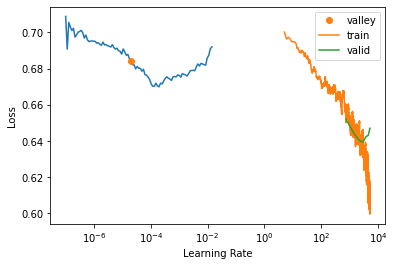

In [5]:
def learner(dls, model_input):
    print("Test")
    model = Learner(dls, model_input, loss_func=fvision.BCEWithLogitsLossFlat(), metrics=petfinder_rmse).to_fp32()
    model.lr_find(end_lr=3e-2)
    model.fit_one_cycle(20, 2e-5, cbs=[SaveModelCallback(),
                                       EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=3)])
    model.recorder.plot_loss()
    model = model.to_fp32()
    model.save('fine-tuned')
    print('Saved')
    model.export()
    return model

learn = learner(dls, health)

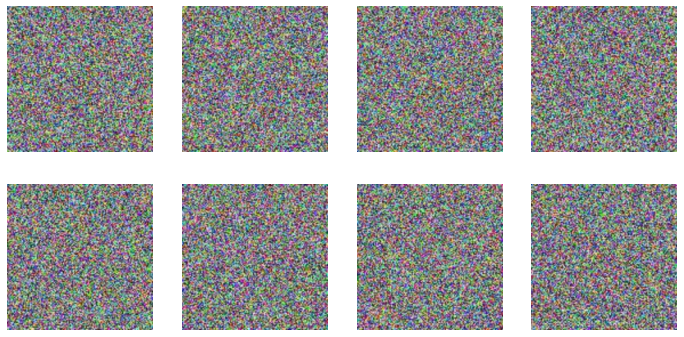

In [6]:
def inference(dataset_path, dls, train_df, learn):
    test_df = pd.read_csv("%s/test.csv"%dataset_path)
    test_df.head()
    test_df['Pawpularity'] = [1]*len(test_df)
    test_df['path'] = test_df['Id'].map(lambda x:str("%s/test/%s" % (dataset_path, x))+'.jpg')
    test_df = test_df.drop(columns=['Id'])
    train_df['norm_score'] = train_df['Pawpularity']/100
    test_dl = dls.test_dl(test_df)
    test_dl.show_batch()
    preds, _ = learn.tta(dl=test_dl, n=5, beta=0)
    sample_df = pd.read_csv(dataset_path+'/sample_submission.csv')
    sample_df['Pawpularity'] = preds.float().numpy()*100
    sample_df.to_csv('submission.csv',index=False)

inference(path, dls, train_df, learn)

In [7]:
def main():
    torch.cuda.empty_cache()
    if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
        os.makedirs('/root/.cache/torch/hub/checkpoints/')
    !cp '../input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'

    torch.cuda.empty_cache()
    # learner(dls, health)


# main()